<h1><center>Redes Neuronales con Keras y Scikit</center></h1>


<center><i>Clasificación binaria: Predicting Red Hat Business Value</i></center>

# <h1>Contenido</h1>

<div class="alert alert-block alert-warning" style="margin-top: 20px">
    <ol>
        <li><a href="#problema">Contexto Analítico</a></li>   
        <li><a href="#ingenieria">Ingeniería de datos</a></li>          
        <li><a href="#arquitectura">Arquitectura propuesta</a></li>
        <li><a href="#evaluaion">Evaluación del Modelo</a></li>
    </ol>
</div>
<br>
<hr>

# <h1 id="problema">Contexto analítico</h1>

Este caso se basa en un reto propuesto por Red Hat en la plataforma Kaggle. (https://www.kaggle.com/c/predicting-red-hat-business-value/data) 

Red Hat es capaz de obtener una importante cantidad de información de comportamiento de sus clientes. El interes de la compañia se basa en la busqueda de mejores metodos para analizar sus clientes para predecir sobre cuales deberian hacer un especial enfasis que podrian convertirse en clientes de alto valor.

En este reto se propone crear un algoritmo de clasificación que identifique los clientes con mayor potencial para convertirse en clientes de alto valor para Red Hat basados en su actividad.

Se cuenta con dos datasets (people.csv y act_train.csv) los cuales cargaremos directamente a Colab.


In [1]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import io
from google.colab import files #Librería necesaria para interactuar con archivos en Colab

In [2]:
#Cargamos los dataset 
# Opcion 1: usando el gestor de archivos grafico
# uploaded = files.upload()
# people = pd.read_csv(io.StringIO(uploaded['people.csv'].decode('utf-8')), sep = ',' )

In [3]:
# Opcion 2 metodo convencional que prefiero
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# para cambiar su directorio a donde tienen sus files
%cd '/content/drive/My Drive/Colab Notebooks/Curso redes neuronales keras y scikit/red_hat'

/content/drive/My Drive/Colab Notebooks/Curso redes neuronales keras y scikit/red_hat


In [5]:
people = pd.read_csv('people.csv', sep = ',', encoding='utf-8')
people.head(3)

people_id  char_1      group_1  char_2  ... char_35 char_36 char_37 char_38
0     ppl_100  type 2  group 17304  type 2  ...    True    True   False      36
1  ppl_100002  type 2   group 8688  type 3  ...    True    True   False      76
2  ppl_100003  type 2  group 33592  type 3  ...   False    True    True      99

[3 rows x 41 columns]

El primer hecho a resaltar es que la información se presenta anonimizada, algo muy común en la ciencia de datos.

Se aprecia una gran cantidad de campos de naturaleza categórica.

In [6]:
#Repetimos el mismo proceso para el csv act_train
activity = pd.read_csv('act_train.csv', sep = ',' )
activity.head(3)

people_id   activity_id        date  ... char_9  char_10 outcome
0   ppl_100  act2_1734928  2023-08-26  ...    NaN  type 76       0
1   ppl_100  act2_2434093  2022-09-27  ...    NaN   type 1       0
2   ppl_100  act2_3404049  2022-09-27  ...    NaN   type 1       0

[3 rows x 15 columns]

# <h1 id="ingenieria">Ingeniería de datos</h1>

Evaluaremos ahora el tamaño de los datasets y la completitud de información en las distintas variables disponibles.

In [7]:
# Verificamos la completitud para el dataset people
print(people.shape)
100*people.isnull().sum()/people.shape[0]

(189118, 41)


people_id    0.0
char_1       0.0
group_1      0.0
char_2       0.0
date         0.0
char_3       0.0
char_4       0.0
char_5       0.0
char_6       0.0
char_7       0.0
char_8       0.0
char_9       0.0
char_10      0.0
char_11      0.0
char_12      0.0
char_13      0.0
char_14      0.0
char_15      0.0
char_16      0.0
char_17      0.0
char_18      0.0
char_19      0.0
char_20      0.0
char_21      0.0
char_22      0.0
char_23      0.0
char_24      0.0
char_25      0.0
char_26      0.0
char_27      0.0
char_28      0.0
char_29      0.0
char_30      0.0
char_31      0.0
char_32      0.0
char_33      0.0
char_34      0.0
char_35      0.0
char_36      0.0
char_37      0.0
char_38      0.0
dtype: float64

In [8]:
#Repetimos el procedimiento con el dataset de activity
print(activity.shape)
100*activity.isnull().sum()/activity.shape[0]

(2197291, 15)


people_id             0.000000
activity_id           0.000000
date                  0.000000
activity_category     0.000000
char_1               92.826849
char_2               92.826849
char_3               92.826849
char_4               92.826849
char_5               92.826849
char_6               92.826849
char_7               92.826849
char_8               92.826849
char_9               92.826849
char_10               7.173151
outcome               0.000000
dtype: float64

Se evidencia que los campos char_1 al char_9 tienen el 92% de sus valores en nulo Esta cantidad es muy elevada para aplicar metodos de imputación, por lo cual optaremos por elminar las columnas con este inconveniente.

In [9]:
activity.columns

Index(['people_id', 'activity_id', 'date', 'activity_category', 'char_1',
       'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8',
       'char_9', 'char_10', 'outcome'],
      dtype='object')

In [10]:
activity.drop(columns=['char_1','char_2', 'char_3', 'char_4', 'char_5', 'char_6',\
                       'char_7', 'char_8','char_9'],inplace=True)
print(activity.shape)
activity.head(3)

(2197291, 6)


people_id   activity_id        date activity_category  char_10  outcome
0   ppl_100  act2_1734928  2023-08-26            type 4  type 76        0
1   ppl_100  act2_2434093  2022-09-27            type 2   type 1        0
2   ppl_100  act2_3404049  2022-09-27            type 2   type 1        0

In [11]:
# Verificamos nuevamente nuestro dataset
print(activity.shape)
100*activity.isnull().sum()/activity.shape[0]

(2197291, 6)


people_id            0.000000
activity_id          0.000000
date                 0.000000
activity_category    0.000000
char_10              7.173151
outcome              0.000000
dtype: float64

# Consolidando nuestros dataframes en uno solo

Para consolidar un dataset debemos tener un par de consideraciones previas: 

* Se aprecia que existen dos variables que tienen los mismos nombres en ambos 
datasets (char_2 y char_10) por lo cual es buena practica renombrar estas columnas para evitar confusiones al momento de unificar las fuentes.
* En el caso de la variable categórica "tipo_actividad" existe una proporción de nulos que podemos reemplazar por la moda.

In [12]:
#Renombramos columnas
activity = activity.rename(columns={"date":"fecha_actividad","char_10":"tipo_actividad"})

In [13]:
#Reenplazamos el tipo de actividad por la moda en aquellos valores faltantes de la columna
activity["tipo_actividad"] = activity["tipo_actividad"].fillna(activity["tipo_actividad"].mode()[0])

In [14]:
#Verificamos el cambio
100*activity.isnull().sum()/activity.shape[0]

people_id            0.0
activity_id          0.0
fecha_actividad      0.0
activity_category    0.0
tipo_actividad       0.0
outcome              0.0
dtype: float64

Ahora unificamos los datasets empleando la función merge y evaluamos la consistencia luego de esta operación 

In [15]:
consolidado = activity.merge(people,on=["people_id"],how="inner")
print("Tamaño previo: ",activity.shape)
print("Nuevo tamaño: ",consolidado.shape)


Tamaño previo:  (2197291, 6)
Nuevo tamaño:  (2197291, 46)


La variable objetivo que clasifica la actividad de los usuarios como potenciales clientes es denominada "outcome", evaluaremos la distribución de este variable: 

In [16]:
print("Distribución de outcome: \n", 100*consolidado["outcome"].value_counts()/consolidado.shape[0])

Distribución de outcome: 
 0    55.60456
1    44.39544
Name: outcome, dtype: float64


Como lo hemos mencionado, las redes neuronales requieren de entrada sólo valores numericos, por lo cual debemos convertir aquellas que no lo son. El dataset consolidado cuenta con 46 variables de tipo booleanas, numericas o categóricas que deben ser transformadas.

In [17]:
types = pd.DataFrame(consolidado.dtypes)

In [18]:
print("Tipos de variables",types.groupby(0).size())

Tipos de variables 0
bool      28
int64      2
object    16
dtype: int64


In [19]:
# Hacemos el reemplazo de valores tipo bool hacia int
consolidado = consolidado.replace({False: 0, True: 1})

types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de reemplazo",types.groupby(0).size())

Tipos de variables luego de reemplazo 0
int64     30
object    16
dtype: int64


In [20]:
print("Distribución de outcome: \n", 100*consolidado["outcome"].value_counts()/consolidado.shape[0])

Distribución de outcome: 
 0    55.60456
1    44.39544
Name: outcome, dtype: float64


# Convirtiendo datos restantes a valores numericos

Si recordamos, el identificador people_id se compone por un prefijo "ppl_" seguido de un número único por usuario.En este caso basta con recortar el prefijo para transformar esta variable en numerica.

In [21]:
consolidado.people_id = consolidado.people_id.str.slice(start=4).astype(float).astype(int)

In [22]:
types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de 2do reemplazo",types.groupby(0).size())

Tipos de variables luego de 2do reemplazo 0
int64     31
object    15
dtype: int64


In [23]:
consolidado.head(3)
#people_id ya es entero

people_id   activity_id fecha_actividad  ... char_36 char_37  char_38
0        100  act2_1734928      2023-08-26  ...       1       0       36
1        100  act2_2434093      2022-09-27  ...       1       0       36
2        100  act2_3404049      2022-09-27  ...       1       0       36

[3 rows x 46 columns]

Al validar el dataset consolidado podemos aplicar la misma metodología previamente mencionada a otro par de columnas:

"activity_id", "activity_category", "group_1", "tipo_actividad"

In [24]:
consolidado[["activity_id", "activity_category", "group_1", "tipo_actividad"]].head(3)

activity_id activity_category      group_1 tipo_actividad
0  act2_1734928            type 4  group 17304        type 76
1  act2_2434093            type 2  group 17304         type 1
2  act2_3404049            type 2  group 17304         type 1

In [25]:
# Aplicamos la conversion slice -> float -> int
consolidado.activity_id = consolidado.activity_id.str.slice(start=5).astype(float).astype(int)
consolidado.activity_category = consolidado.activity_category.str.slice(start=5).astype(float).astype(int)
consolidado.group_1 = consolidado.group_1.str.slice(start=6).astype(float).astype(int)
consolidado.tipo_actividad = consolidado.tipo_actividad.str.slice(start=5).astype(float).astype(int)

In [26]:
#Verificamos
types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de 3er reemplazo",types.groupby(0).size())

Tipos de variables luego de 3er reemplazo 0
int64     35
object    11
dtype: int64


In [27]:
consolidado[["activity_id", "activity_category", "group_1", "tipo_actividad"]].head(3)

activity_id  activity_category  group_1  tipo_actividad
0      1734928                  4    17304              76
1      2434093                  2    17304               1
2      3404049                  2    17304               1

Evaluemos las variables que siguen siendo tipo object y la cantidad de valores distintos que poseen

In [28]:
categoricas = types.index[types[0] == 'O'].values
categoricas

array(['fecha_actividad', 'char_1', 'char_2', 'date', 'char_3', 'char_4',
       'char_5', 'char_6', 'char_7', 'char_8', 'char_9'], dtype=object)

In [29]:
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(consolidado[line].unique()))+" distinct values")

La variable fecha_actividad contiene: 411 distinct values
La variable char_1 contiene: 2 distinct values
La variable char_2 contiene: 3 distinct values
La variable date contiene: 1196 distinct values
La variable char_3 contiene: 43 distinct values
La variable char_4 contiene: 25 distinct values
La variable char_5 contiene: 9 distinct values
La variable char_6 contiene: 7 distinct values
La variable char_7 contiene: 25 distinct values
La variable char_8 contiene: 8 distinct values
La variable char_9 contiene: 9 distinct values


Del listado anterior resaltamos dos variables tipo fecha ("date", "fecha_actividad") Para la red neuronal representa una oportunidad poder extraer una serie de caracteristicas adicionales que le permitan entender patrones estacionales de diferentes periodicidades (diario, semanal, mensual, etc) es por esto que crearemos una serie de variables adicionales (de naturaleza numérica) a partir de estas dos fechas:

In [30]:
#Convertimos la variable objeto en datetime
consolidado["date"] = pd.to_datetime(consolidado["date"])

In [31]:
#Creamos nuevas variables
consolidado["dia"] = consolidado["date"].dt.day
consolidado["dia_semana"] = consolidado["date"].dt.weekday
consolidado["semana"] = consolidado["date"].dt.week
consolidado["mes"] = consolidado["date"].dt.month
consolidado["trimestre"] = consolidado["date"].dt.quarter
consolidado["año"] = consolidado["date"].dt.year

In [32]:
#Repetimos el procedimiento anterior con fecha_actividad
consolidado["fecha_actividad"] = pd.to_datetime(consolidado["fecha_actividad"])
consolidado["dia_actividad"] = consolidado["fecha_actividad"].dt.day
consolidado["dia_semana_actividad"] = consolidado["fecha_actividad"].dt.weekday
consolidado["semana_actividad"] = consolidado["fecha_actividad"].dt.week
consolidado["mes_actividad"] = consolidado["fecha_actividad"].dt.month
consolidado["trimestre_actividad"] = consolidado["fecha_actividad"].dt.quarter
consolidado["año_actividad"] = consolidado["fecha_actividad"].dt.year

In [33]:
types = pd.DataFrame(consolidado.dtypes)
print("Tipos de variables luego de 4to reemplazo",types.groupby(0).size())

Tipos de variables luego de 4to reemplazo 0
int64             47
datetime64[ns]     2
object             9
dtype: int64


In [34]:
consolidado.head(3)

people_id  activity_id  ... trimestre_actividad  año_actividad
0        100      1734928  ...                   3           2023
1        100      2434093  ...                   3           2022
2        100      3404049  ...                   3           2022

[3 rows x 58 columns]

Con la relativa pequeña cantidad de variables categoricas que manejamos vamos a proceder a realizar la conversión por One Hot Encoding

In [35]:
categoricas = types.index[types[0] == 'O'].values
for line in categoricas:
 print("La variable "+ line +" contiene:",str(len(consolidado[line].unique()))+" distinct values")

La variable char_1 contiene: 2 distinct values
La variable char_2 contiene: 3 distinct values
La variable char_3 contiene: 43 distinct values
La variable char_4 contiene: 25 distinct values
La variable char_5 contiene: 9 distinct values
La variable char_6 contiene: 7 distinct values
La variable char_7 contiene: 25 distinct values
La variable char_8 contiene: 8 distinct values
La variable char_9 contiene: 9 distinct values


In [36]:
# usamos skilearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Elegimos primero la columna char_6 para posterior replicar a las demas
columna='char_6'

# Declaramos el constructor del encoder
le = LabelEncoder()

# Creamos un encoder ajustado a  los datos de char_6, reajustandolo el tamaño
le_ajustado=le.fit_transform(consolidado[columna]).reshape(-1,1)
# reshape es necesario porque la forma original es un array del tipo vector fila

# le_ajustado es vector columna  con las variables codificadas de la forma "label Encoder"
le_ajustado[:10]

array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [1]])

In [37]:
encoder = OneHotEncoder(sparse=False)
column = [columna+ "_"+ str(i) for i in le.classes_]
column

['char_6_type 1',
 'char_6_type 2',
 'char_6_type 3',
 'char_6_type 4',
 'char_6_type 5',
 'char_6_type 6',
 'char_6_type 7']

Vamos a crear una columna con cada uno de las clases

In [38]:
# A partir del labelEncoder obtenemos el oneHotEncoder
encoder.fit_transform(le_ajustado)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [39]:
# Creamos un DataFrame pasando como primer parametro el one-hot-encoder y como segundo parametro el nombre de las columnas
pd.DataFrame(encoder.fit_transform(le_ajustado),columns=column).head(10)

char_6_type 1  char_6_type 2  ...  char_6_type 6  char_6_type 7
0            0.0            0.0  ...            0.0            0.0
1            0.0            0.0  ...            0.0            0.0
2            0.0            0.0  ...            0.0            0.0
3            0.0            0.0  ...            0.0            0.0
4            0.0            0.0  ...            0.0            0.0
5            0.0            0.0  ...            0.0            0.0
6            0.0            0.0  ...            0.0            0.0
7            0.0            0.0  ...            0.0            0.0
8            0.0            1.0  ...            0.0            0.0
9            0.0            1.0  ...            0.0            0.0

[10 rows x 7 columns]

En esto consiste el one-hot encoder, solo las columnas que tenian esta caracteristica en el DF original entran un valor de 1, las demas un valor de 0. 

Condensamos los pasos anteriores ahora en una funcion para realizar el one-hot encoder para todo el dataframe

In [40]:
#Se define función que captura el dataframe y la columna para retornar un dataframe luego de OHE
def crea_OneHotEncoding(df, columna):
  le = LabelEncoder()
  le_ajustado=le.fit_transform(df[columna]).reshape(-1,1)
  encoder = OneHotEncoder(sparse=False)
  column = [columna+ "_"+ str(i) for i in le.classes_]
  data = encoder.fit_transform(le_ajustado)
  return(pd.DataFrame(data,columns =column))

In [41]:
numeric_columns = list(set(types.index[types[0] =="int64"].values) - set(["outcome"]))
variables_consolidadas = consolidado[numeric_columns]
objetivo = consolidado["outcome"]

categoricas = types.index[types[0] == 'O'].values
for column in categoricas:
  df = crea_OneHotEncoding(consolidado,column)
  variables_consolidadas = pd.concat([variables_consolidadas,df],axis=1)
  print("Columna ",column, " transformada!")

print("Tamaño final del dataset transformado:",variables_consolidadas.shape)

Columna  char_1  transformada!
Columna  char_2  transformada!
Columna  char_3  transformada!
Columna  char_4  transformada!
Columna  char_5  transformada!
Columna  char_6  transformada!
Columna  char_7  transformada!
Columna  char_8  transformada!
Columna  char_9  transformada!
Tamaño final del dataset transformado: (2197291, 177)


In [42]:
variables_consolidadas.head(3)

char_27  mes  char_18  ...  char_9_type 7  char_9_type 8  char_9_type 9
0        1    6        0  ...            0.0            0.0            0.0
1        1    6        0  ...            0.0            0.0            0.0
2        1    6        0  ...            0.0            0.0            0.0

[3 rows x 177 columns]

# Evaluando Métricas de desempeño

Con el dataset ya consolidado procedemos a seleccionar las muestras de entrenamiento, validación y prueba

In [43]:
from sklearn.model_selection import train_test_split

# Obtenemos sets de entrenamiento y prueba con relación 80:20
x_train, x_test, y_train, y_test = train_test_split(variables_consolidadas,objetivo, test_size=0.2,random_state=2020)

Guardo los datsets para evitar reprocesamiento en caso de que colapse Collab

In [44]:
# x_train.to_csv('x_train.csv')
# x_test.to_csv('x_test.csv')
# y_train.to_csv('y_train.csv')
# y_test.to_csv('y_test.csv')

Validamos el tamaño de los sets entrenamiento y pruebas

In [45]:
print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)

Shape of x_train: (1757832, 177)
Shape of x_test: (439459, 177)


In [46]:
# Entrenamiento y validación con relación 90:10
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=2020)

print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)
print("Shape of y_val:",y_val.shape)

Shape of x_train: (1582048, 177)
Shape of x_test: (439459, 177)
Shape of x_val: (175784, 177)
Shape of y_train: (1582048,)
Shape of y_test: (439459,)
Shape of y_val: (175784,)


# <h1 id="arquitectura">Arquitectura Propuesta</h1>

Una vez consolidado los sets de información de entrenamiento, validacion y pruebas ya podemos iniciar a modelar nuestra red neuronal con las siguientes consideraciones:
* Debido a que el problema consiste en un clasificador binario la función de perdidas más recomendada es "binary_crossentropy".
* De manera similar una función de activación que se adecua al tipo de problema es la "sigmoid".
* La metrica para evaluación sera la precisión "accuracy"
* Debido a la gran cantidad de información el entrenamiento tomara más tiempo, en este escenario se implementaran arquitecturas más pequeñas con pocas epocas de entrenamiento y se escalará el modelo a medida los resultados del accuracy mejoren.

In [47]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

In [48]:
#Red neuronal pequeña inicial
# Tenemos 177 variables de entrada
# 2^7 = 128 neuronas < 177 entradas
# 2^8 = 256 neuronas requeridas

model = Sequential()
model.add(Dense(256,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid")) 
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])

In [49]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               45568     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 111,617
Trainable params: 111,617
Non-trainable params: 0
_________________________________________________________________
None


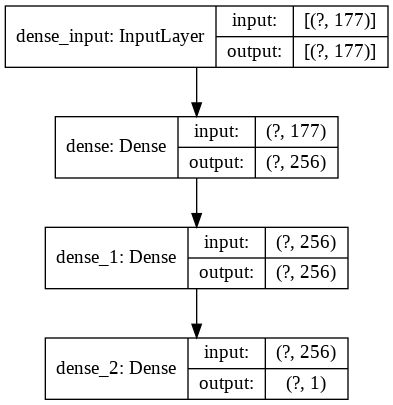

In [50]:
plot_model(model, to_file='model.png',show_shapes=True)

Hacemos el entrenamiento de la red con 5 iteraciones/epocas y un batch de 128 registros

In [51]:
# Libero RAM guardando las variables de los dataframe como None para poder continuar con el ejercicio
# y evitar que Google Collab se reinice por falta de RAM,  estas existen ya como un dataset
variables_consolidadas = None
objetivo = None
people = None
activity = None

In [ ]:
model.fit(x_train,y_train, validation_data = (x_val,y_val),epochs=5, batch_size=128)

Epoch 1/5
12360/12360 [==============================] - 51s 4ms/step - loss: 628.1542 - accuracy: 0.6332 - val_loss: 3.8725 - val_accuracy: 0.7602
Epoch 2/5
12360/12360 [==============================] - 51s 4ms/step - loss: 2.3792 - accuracy: 0.7264 - val_loss: 0.4346 - val_accuracy: 0.7773
Epoch 3/5
12360/12360 [==============================] - 51s 4ms/step - loss: 0.6782 - accuracy: 0.5979 - val_loss: 0.6865 - val_accuracy: 0.5574
Epoch 4/5
12360/12360 [==============================] - 49s 4ms/step - loss: 0.7057 - accuracy: 0.5561 - val_loss: 0.6862 - val_accuracy: 0.5582
Epoch 5/5
12360/12360 [==============================] - 49s 4ms/step - loss: 0.6995 - accuracy: 0.5563 - val_loss: 0.6865 - val_accuracy: 0.5573


In [53]:
print("Distribución de outcome: \n", 100*consolidado["outcome"].value_counts()/consolidado.shape[0])

Distribución de outcome: 
 0    55.60456
1    44.39544
Name: outcome, dtype: float64


In [54]:
#Red neuronal de 2 capas
model = Sequential()
model.add(Dense(512,input_dim = x_train.shape[1],activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation = "sigmoid"))

In [55]:
model.compile(optimizer = "Adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train, validation_data = (x_val,y_val),epochs=3, batch_size=128)

Epoch 1/3
12360/12360 [==============================] - 59s 5ms/step - loss: 143.1579 - accuracy: 0.5532 - val_loss: 0.6866 - val_accuracy: 0.5573
Epoch 2/3
12360/12360 [==============================] - 56s 5ms/step - loss: 1.2154 - accuracy: 0.5560 - val_loss: 0.6866 - val_accuracy: 0.5573
Epoch 3/3
12360/12360 [==============================] - 56s 4ms/step - loss: 0.6869 - accuracy: 0.5561 - val_loss: 0.6868 - val_accuracy: 0.5573


A pesar de haber escalado el tamaño de la red los resultados siguen siendo descepcionantes. En este caso el mejor paso a seguir es volver a validar los datos disponibles. En este punto existen dos opciones a explorar: 
* Estandarizar las variables numericas disponibles.
* Volver a realizar el One Hot Encoding.

Revisemos los datos con los que estamos evaluando la red

In [56]:
x_train.head(3)

char_27  mes  char_18  ...  char_9_type 7  char_9_type 8  char_9_type 9
1742909        0    6        1  ...            0.0            0.0            0.0
711687         1   11        0  ...            0.0            0.0            1.0
2054827        0   10        0  ...            0.0            0.0            0.0

[3 rows x 177 columns]

Observamos en el dataframe muchas columnas con valores que  van a rangos numericos altos mas alla de los valores binario que utilizamos, recordemos que el funcionamiento de una red neuronal es una suma ponderada de todas sus entradas, por lo que este problema de escalas puede estar desncadenando que nuestro desempeño sea mediocre

Para resolver esto debemos realizar como primer paso una estandarizacion de todas las variables

In [ ]:
from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)